# Prediction of surgery vs non-sergery using functional profile

Train machine learning models on sepecies abundance to predict if the sample is from a patient tha has undergone surgery

In [1]:
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#load pathway abundance 

df_pathway=pd.read_csv('./data/Filtered_normalized_cpm_pathways_new_unstratified.csv',index_col=0)
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)

#create dictionary to organize the sample, subjects and their surgery status
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))
dic_subject=dict(zip(list(df_meta.host_id),list(df_meta.surgery_type)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))

## RandomForest classifier for 2 groups: surgery vs no surgery


### Split test and training samples: Separates by subjects
make sure subject in training data does not overlap with subjects in test data

In [16]:
from random import sample 

# Create a lists of subject that have done surgery, and subjects that have not done surgery 

subject_nonsurgery=[i for i in dic_subject.keys() if dic_subject[i]=='none']
subject_surgery=[i for i in dic_subject.keys() if i not in subject_nonsurgery]

# write a function to randomly split test and training set, so that the subjects in test and training do not overlap 
# 70% percent of the subjects are in training samples while 30% subjects are in test samples
def split_data(df_meta,df_pathway):
    #use randome sample to select ~70% subject from each group as training data 
    sub_train_nosurg=sample(subject_nonsurgery,int(len(subject_nonsurgery)*0.7))
    sub_train_surg=sample(subject_surgery,int(len(subject_surgery)*0.7))
    sub_train=sub_train_nosurg+sub_train_surg

    #map subjects back to samples and build the training dataset 
    sample_train=[i for i in df_pathway.columns if dic_sample_host[i] in sub_train]
    sample_test=[i for i in df_pathway.columns if i not in sample_train]
    X_train=df_pathway[sample_train]
    X_test=df_pathway[sample_test]
    
    ## create the output 
    y_train=[]
    for i in X_train.columns: 
        if dic_surgery[i]=='none': 
            y_train.append(0)
        else: 
            y_train.append(1)

    y_test=[]
    for i in X_test.columns: 
        if dic_surgery[i]=='none': 
            y_test.append(0)
        else: 
            y_test.append(1)
    return X_train, X_test,y_test,y_train

X_train, X_test,y_test,y_train=split_data(df_meta,df_pathway)

In [17]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train.T, y_train)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train.T, y_train, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf = class_rf.predict(X_test.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print 'Prediction accuracy score on the test data: ', accuracy_score(y_test, y_rf) 
average_precision=average_precision_score(y_test, y_rf) 
print 'Average precision-recall score: ', average_precision

cross-validation on the training data: 
[0.95652174 0.86956522 0.86956522 0.7826087  0.86956522 0.81818182
 0.77272727 0.86363636 0.80952381 0.71428571]
Prediction accuracy score on the test data:  0.8311688311688312
Average precision-recall score:  0.7755952380952381


Text(0.5,1,'Precision-Recall curve generated using pathway abundance: AP=0.78')

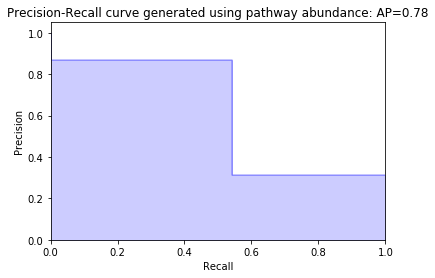

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_rf)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.3,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve generated using pathway abundance: AP={0:0.2f}'.format(
          average_precision))

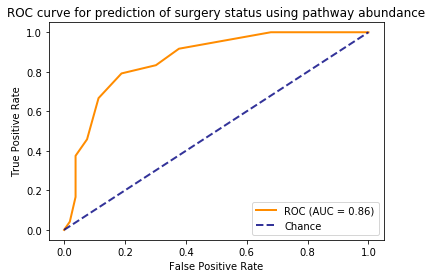

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
probas_= class_rf.fit(X_train.T, y_train).predict_proba(X_test.T)

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2,color='darkorange',
      label='ROC (AUC = %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for prediction of surgery status using pathway abundance')
plt.legend(loc="lower right")
plt.show()

## Randomly split data, train and test the model for 100 times 
### Record ad calculate the average precision-recall score 
### identify the most important species that had the highest occurance

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

#define classifier 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)

pcscore_list=[]
featuelist=[]
for i in range(100): 
    print i 
    X_train, X_test,y_test,y_train=split_data(df_meta,df_pathway)
    class_rf.fit(X_train.T, y_train)
    # Predict on new data
    y_rf = class_rf.predict(X_test.T)
    # calculate the accuracy score of the classifier 
    pcscore_list.append(average_precision_score(y_test, y_rf))
    ind_top30=sorted(range(len(class_rf.feature_importances_)), key=lambda i: class_rf.feature_importances_[i])[-30:]
    for i in ind_top30: 
        featuelist.append(df_pathway.index[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [ ]:
# count the most important features that overlapped in 100 runs 
dic_count={}
for s in set(featuelist): 
    count=featuelist.count(s)
    dic_count[s]=count
dic_count

import operator
sorted_x = sorted(dic_count.items(), key=operator.itemgetter(1))
sorted_x